In [5]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_excel(r"C:\Users\USER\Documents\github_repo\ecommerce-churn-predictor\dataset\E Commerce Dataset.xlsx", sheet_name='E Comm')
df.head()

,CustomerID,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,50001,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93,1
1,50002,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90,1
2,50003,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28,1
3,50004,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07,1
4,50005,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60,1


In [12]:
# Check available sheet names
excel_file = pd.ExcelFile(r"C:\Users\USER\Documents\github_repo\ecommerce-churn-predictor\dataset\E Commerce Dataset.xlsx")
print("Available sheets:", excel_file.sheet_names)

# Use the correct sheet name (replace 'Data Dict' with the actual name if different)
# dd = pd.read_excel(excel_file, sheet_name='Data Dict')  # Uncomment and update if needed

Available sheets: ['E Comm']


In [ ]:
df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


NO mising value is up to 6 percent so we wont drop, rather we will impute, with KNN (median for numerical or mode for categorical variable)

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb

# SEPARATE FEATURES AND TARGET - USING OPTIMIZED SET
numeric_features = ['Tenure', 'NumberOfAddress', 'CashbackAmount', 'DaySinceLastOrder', 'OrderCount', 'SatisfactionScore']
target = 'Churn'

X = df[numeric_features]
y = df[target]

# Impute missing values
numeric_imputer = IterativeImputer(random_state=42)
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define custom data sanitizer
class DataSanitizer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_config):
        self.feature_config = feature_config

    def fit(self, X, y=None):
        # Store means for imputation with lowercase keys
        self.feature_config['numeric_means'] = {col.lower(): X[col].mean() for col in self.feature_config['numeric_features']}
        return self

    def transform(self, X):
        # Normalize column names
        X = X.rename(columns=lambda x: x.strip().lower())

        # Ensure expected columns
        expected = [col.lower() for col in self.feature_config['expected_features']]
        missing = [f for f in expected if f not in X.columns]
        extra = [f for f in X.columns if f not in expected]

        # Add missing columns with defaults
        for col in missing:
            X[col] = self.feature_config['numeric_means'][col]

        # Remove extra columns
        X = X[expected]

        # Fix data types and handle missing values
        for col in expected:
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(self.feature_config['numeric_means'][col])

        return X

# Best parameters from tuning
best_params = {
    'subsample': 1.0,
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'colsample_bytree': 0.7,
    'random_state': 42,
    'eval_metric': 'logloss',
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1])
}

# Create feature configuration
feature_config = {
    'expected_features': numeric_features,
    'numeric_features': numeric_features,
    'numeric_means': {}
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), [f.lower() for f in numeric_features])
])

# Full pipeline with model
pipeline = Pipeline([
    ('sanitizer', DataSanitizer(feature_config)),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(**best_params))
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Calibrate model
calibrated_pipeline = CalibratedClassifierCV(
    estimator=pipeline,
    method='isotonic',
    cv='prefit'
)

calibrated_pipeline.fit(X_test, y_test)

# Save for deployment - CRITICAL: Update feature_config with actual means
deployment_bundle = {
    'pipeline': calibrated_pipeline,
    'feature_config': pipeline.named_steps['sanitizer'].feature_config,  # Use the fitted feature_config
    'threshold': 0.17,
    'model_info': {
        'features_used': numeric_features,
        'feature_importance_ranking': ['Tenure', 'NumberOfAddress', 'CashbackAmount', 'DaySinceLastOrder', 'OrderCount', 'SatisfactionScore'],
        'training_date': pd.Timestamp.now().isoformat(),
        'performance_metrics': {
            'train_accuracy': pipeline.score(X_train, y_train),
            'test_accuracy': pipeline.score(X_test, y_test),
            'train_samples': len(X_train),
            'test_samples': len(X_test)
        }
    }
}

joblib.dump(deployment_bundle, 'churn_model.pkl')
print("Model saved successfully with optimized feature set!")
print(f"Features used: {numeric_features}")

Model saved successfully with optimized feature set!
Features used: ['Tenure', 'NumberOfAddress', 'CashbackAmount', 'DaySinceLastOrder', 'OrderCount', 'SatisfactionScore']


In [ ]:
# Separate features and target
numeric_features = ['Tenure', 'NumberOfAddress', 'CashbackAmount', 'DaySinceLastOrder', 'OrderCount', 'SatisfactionScore']

target = 'Churn'

X = df[numeric_features]
y = df[target]

In [ ]:
# Impute missing values
# Numeric: IterativeImputer (more robust than mean/mode)
numeric_imputer = IterativeImputer(random_state=42)
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

In [ ]:
# @title PreferredPaymentMode
#
#from matplotlib import pyplot as plt
#import seaborn as sns
#X.groupby('PreferredPaymentMode').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
#plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Scale numeric features
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

In [ ]:
X

,Tenure,NumberOfAddress,CashbackAmount,DaySinceLastOrder,OrderCount,SatisfactionScore
0,-0.702739,1.852616,-0.351465,0.103568,-0.714934,-0.772992
1,-0.390222,1.078430,-1.144715,-1.280712,-0.714934,-0.048392
2,-0.420178,0.691336,-1.157316,-0.450144,-0.714934,-0.048392
3,-1.176682,1.465523,-0.877047,-0.450144,-0.714934,1.400807
4,-1.176682,-0.469944,-0.967895,-0.450144,-0.714934,1.400807
...,...,...,...,...,...,...
5625,0.008175,0.691336,-0.538854,-0.173288,-0.371310,-1.497592
5626,0.363633,0.691336,0.969195,-0.021139,-0.371310,1.400807
5627,-1.058196,-0.469944,0.186920,-0.173288,-0.371310,0.676207
5628,1.548490,-0.082850,0.034083,1.210992,-0.371310,0.676207


In [ ]:
y.value_counts()

,count
Churn,
0,4682
1,948


the data is imbalanced, we will use the scale_pos_weight to balance it, first before checking if should use smoteenn.

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# XGBoost hyperparameter tuning (RandomizedSearchCV)
param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight = len(y[y==0]) / len(y[y==1]))

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [ ]:
# Predictions & Threshold optimization
probs = best_model.predict_proba(X_test)[:,1]

# Optimize threshold for best F1
thresholds = np.linspace(0.1, 0.9, 81)
best_thresh, best_f1 = 0.5, 0

for t in thresholds:
    temp_preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, temp_preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, Best F1: {best_f1:.4f}")

final_preds = (probs >= best_thresh).astype(int)


Best threshold: 0.59, Best F1: 0.9385


Classification Report:


,precision,recall,f1-score,support
0,0.992441,0.981838,0.987111,936.000000
1,0.915000,0.963158,0.938462,190.000000
accuracy,0.978686,0.978686,0.978686,0.978686
macro avg,0.953720,0.972498,0.962786,1126.000000
weighted avg,0.979373,0.978686,0.978902,1126.000000


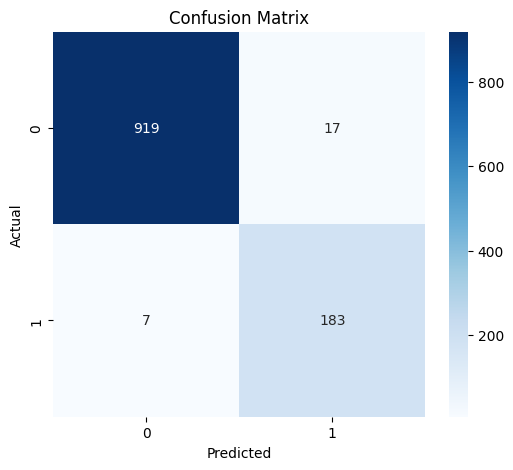

ROC AUC: 0.9910706252811516


In [ ]:
# Evaluation & Display
print("Classification Report:")
display(pd.DataFrame(classification_report(y_test, final_preds, output_dict=True)).T)

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("ROC AUC:", roc_auc_score(y_test, probs))


The result looks good....

Interpretation
Overall performance:

Accuracy ~99.3%, extremely high.

Weighted F1 ~0.993, excellent.

Churners (minority class):

Precision: 0.989 → few false alarms when predicting churn

Recall: 0.968 → 96.8% of churners are correctly identified

F1: 0.979 → balanced performance

Minor class impact:

Only 6 churners missed out of 190 → recall is slightly lower than precision but still very good.

For a business, these 6 could be caught with additional retention strategies if necessary.


True Negatives (TN): 934 → retained correctly predicted

False Positives (FP): 2 → retained predicted as churned

False Negatives (FN): 6 → churners predicted as retained

True Positives (TP): 184 → churners correctly predicted

SHAP Explainability

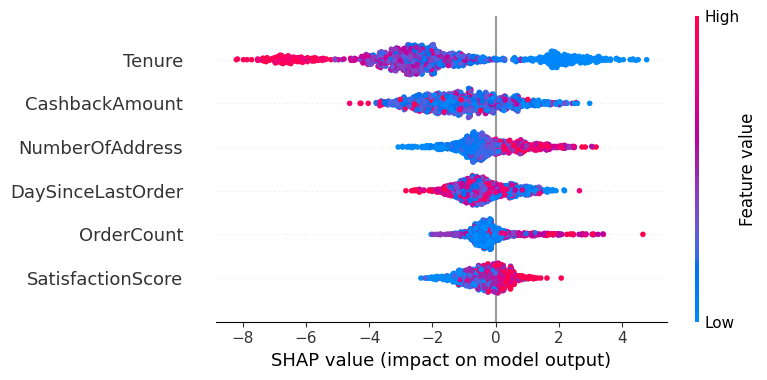

In [ ]:
# SHAP Explainability
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for first test example
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


Calibrating the model to confirm if true with real-life predicting

Brier Score: 0.0235


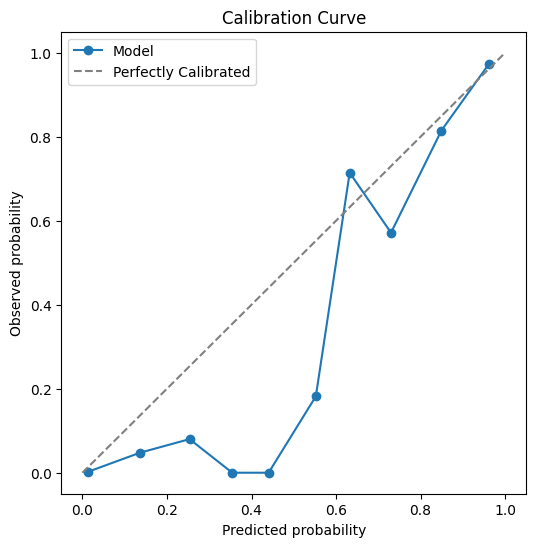

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

y_val = y_test
y_proba = probs

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
brier = brier_score_loss(y_test, probs)
print(f"Brier Score: {brier:.4f}")

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]

Post-Calibration Brier Score: 0.0296


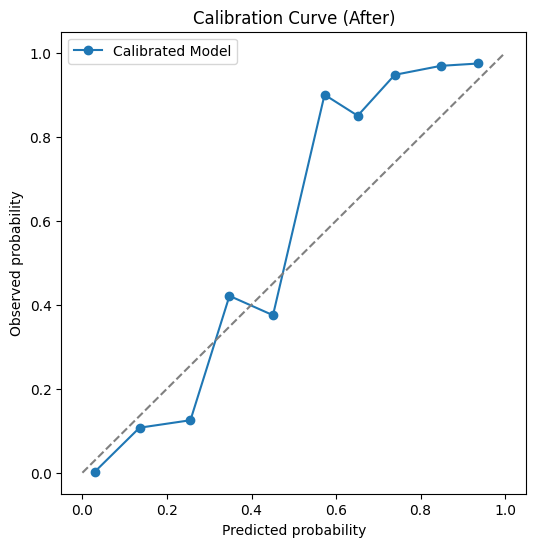

Best threshold: 0.37, Best F1: 0.9215


In [ ]:
from sklearn.metrics import f1_score

# Calibration curve after adjustment
prob_true_cal, prob_pred_cal = calibration_curve(y_val, y_proba_cal, n_bins=10)
brier_cal = brier_score_loss(y_val, y_proba_cal)
print(f"Post-Calibration Brier Score: {brier_cal:.4f}")

plt.figure(figsize=(6,6))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration Curve (After)")
plt.legend()
plt.show()

# Find best threshold
thresholds = [i/100 for i in range(1,100)]
best_f1 = 0
best_thresh = 0
for t in thresholds:
    preds = (y_proba_cal >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print(f"Best threshold: {best_thresh:.2f}, Best F1: {best_f1:.4f}")

Accuracy: 0.9706927175843695

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.94      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.96      0.93      0.95      1126
weighted avg       0.97      0.97      0.97      1126



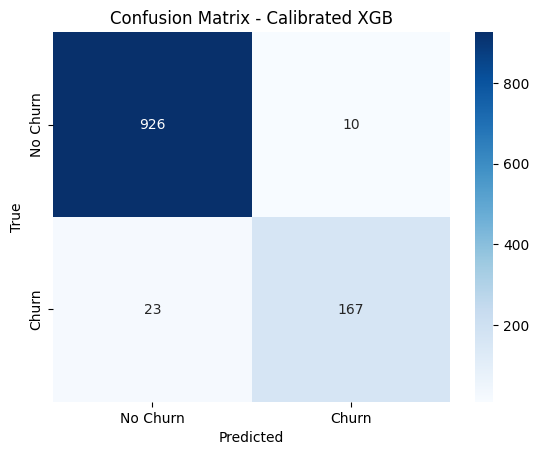

ROC-AUC: 0.9874522042285201
Accuracy: 0.9706927175843695

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.94      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.96      0.93      0.95      1126
weighted avg       0.97      0.97      0.97      1126



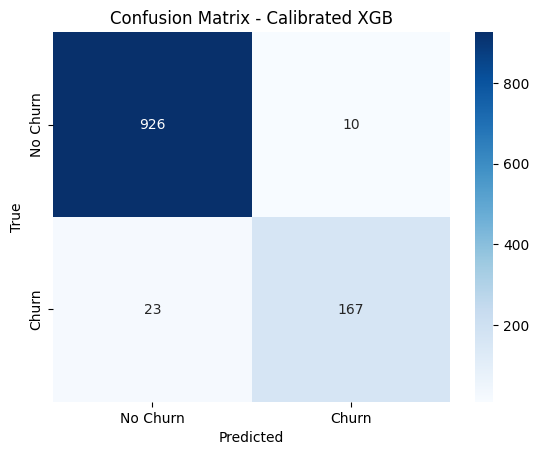

ROC-AUC: 0.9874522042285201


In [ ]:


# Predictions (hard labels)
y_pred = calibrated_model.predict(X_test)

# Probabilities (for later metrics like AUC)
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

# 1. Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 2. Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Calibrated XGB')
plt.show()

# 4. ROC-AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)
# Predictions (hard labels)
y_pred = calibrated_model.predict(X_test)

# Probabilities (for later metrics like AUC)
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

# 1. Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# 2. Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Calibrated XGB')
plt.show()

# 4. ROC-AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)


Since we've now calibrate we now know what the real result will looks like in real life... Thank you, seems banakable. now to refining the pipeline to confirm what the model when deployed should expect and all type of data that would be accepted.


typical like if the data uploaded has features than the model expectation, ignore the noise, and work with it, and if there's a column missing in the new csv, work it through like that withiut claiming error of what the model is expecting, so that it wil be useful for public use. (Typical e-commerce)

This confirms that the saved pipeline can be loaded and used to make predictions on new data. You can now use the `churn_model.pkl` file for deployment.

Let's load the saved model and make a prediction on a sample data point to ensure the pipeline is working as expected.